In [58]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon
import duckdb
import seaborn as sns

In [59]:
def create_hexagons(geoJson):

    polyline_arr = []
    lat = []
    lng = []
    for r in range (0, len(geoJson['coordinates'])):
        polyline = geoJson['coordinates'][r][0]
        polyline = [[x[1], x[0]] for x in polyline]
        polyline.append(polyline[0])
        polyline_arr.append(polyline)
        lat.extend([p[0] for p in polyline])
        lng.extend([p[1] for p in polyline])
    
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    for el in polyline_arr:
        my_PolyLine=folium.PolyLine(locations=el,weight=8,color="green")
        m.add_child(my_PolyLine)

    list_h3shape = []
    for el in polyline_arr:
        flat_l = [x for xs in el for x in xs]
        it = iter(flat_l)
        list_of_tpl = list(zip(it, it))
        list_h3shape.append(h3.LatLngPoly(list_of_tpl))
    
    
    h3_ms = h3.LatLngMultiPoly(*list_h3shape)
    hexagons = list(h3.polygon_to_cells(h3_ms, 8))
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.cells_to_h3shape([hex], tight=False)
        outlines = [loop for polygon in polygons for loop in polygon.outer]
        polyline = np.array(outlines).tolist()
        polyline.append(polyline[0])
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=3,color='red')
        m.add_child(my_PolyLine)
        
    polylines_x = []
    for j in range(len(polylines)):
        a = np.column_stack((np.array(polylines[j])[:,1],np.array(polylines[j])[:,0])).tolist()
        polylines_x.append([(a[i][0], a[i][1]) for i in range(len(a))])
        
    polygons_hex = pd.Series(polylines_x).apply(lambda x: Polygon(x))

    return m, polygons_hex, polylines

In [60]:
def visualize_polygons(geometry):
    lats, lons = get_lat_lon(geometry)
    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=9, tiles='cartodbpositron')
    overlay = gpd.GeoSeries(geometry).to_json()
    folium.GeoJson(overlay, name = 'boundary').add_to(m)
    return m

In [61]:
def get_lat_lon(geometry): 
    lon = geometry.apply(lambda x: x.x if x.geom_type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.geom_type == 'Point' else x.centroid.y)
    return lat, lon

In [62]:
def visualize_hexagons(hexagons, color="red", folium_map=None):

    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.cells_to_h3shape([hex], tight=False)
        outlines = [loop for polygon in polygons for loop in polygon.outer]
        polyline = np.array(outlines).tolist()
        polyline.append(polyline[0])
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=20, tiles='cartodbpositron')
    else:
        m = folium_map
        
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

In [63]:
def create_choropleth(data, json, columns, legend_name, feature, bins):
    
    lat, lon = get_lat_lon(data['geometry'])
    m = folium.Map(location=[sum(lat)/len(lat), sum(lon)/len(lon)], zoom_start=10, tiles='cartodbpositron')
    folium.Choropleth(
        geo_data=json,
        name="choropleth",
        data=data,
        columns=columns,
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        nan_fill_color = 'black',
        bins = bins
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m

In [64]:
h3_address = h3.latlng_to_cell(45.035470, 38.975313,  9) # 9 - индекс, определяющий размер гексагона                                                                                                     
#visualize_hexagons([h3_address])

In [65]:
cities = ['Москва']
polygon_krd = ox.features_from_place(cities, {'boundary':'administrative'}).reset_index()

In [66]:
polygon_krd = polygon_krd[polygon_krd['name'] == 'Москва']
polygon_krd = polygon_krd[polygon_krd['element_type'] == 'relation']

In [67]:
#visualize_polygons(polygon_krd['geometry'])

In [68]:
geoJson = json.loads(gpd.GeoSeries(polygon_krd['geometry']).to_json())
geoJson = geoJson['features'][0]['geometry']

In [69]:
#geoJson = {'type':'Polygon','coordinates': [np.column_stack((np.array(geoJson['coordinates'][0])[:, 1], np.array(geoJson['coordinates'][0])[:, 0])).tolist()]}

In [70]:
#m, polygons, polylines = create_hexagons(geoJson)
m, polygons, polylines = create_hexagons(geoJson)

In [71]:
m

In [72]:
#m.save('demo.html')

In [73]:
gdf_2 = pd.DataFrame(polygons, columns = ['geometry'])
gdf_2['polylines'] = polylines
gdf_2['geometry'] = gdf_2['geometry'].astype(str)
geometry_uniq = pd.DataFrame(gdf_2['geometry'].drop_duplicates())
geometry_uniq['id'] = np.arange(len(geometry_uniq)).astype(str)
gdf_2 = gdf_2.merge(geometry_uniq, on = 'geometry')
gdf_2['geometry'] = gdf_2['geometry'].apply(wkt.loads)
gdf_2 = gpd.GeoDataFrame(gdf_2, geometry='geometry')

In [74]:
gdf_2.head()

geometry  \
0  POLYGON ((36.90654 55.31941, 36.89877 55.31892...   
1  POLYGON ((36.90549 55.32771, 36.90990 55.32381...   
2  POLYGON ((36.90654 55.31941, 36.91094 55.31551...   
3  POLYGON ((37.53751 55.47111, 37.52966 55.47065...   
4  POLYGON ((37.47422 55.64740, 37.48209 55.64787...   

                                           polylines id  
0  [[55.31941115010275, 36.90653602608302], [55.3...  0  
1  [[55.32770983265543, 36.90549390428869], [55.3...  1  
2  [[55.31941115010275, 36.90653602608302], [55.3...  2  
3  [[55.47111346830035, 37.53750628846496], [55.4...  3  
4  [[55.64740217056055, 37.47421664105019], [55.6...  4

In [75]:
cursor = duckdb.connect()
sql = """\
select t.camera, t.unom, t.cars_cnt, 
t.geo::json->'coordinates'->1 as lat,
t.geo::json->'coordinates'->0 as lon from 'camera_cars_ds.parquet' t
"""

df_cameras = cursor.sql(sql).df()
cursor.close()

In [76]:
gdf_1 = gpd.GeoDataFrame(df_cameras, geometry=gpd.points_from_xy(df_cameras.lon, df_cameras.lat))

In [77]:
gdf_1.head()

camera    unom  cars_cnt           lat           lon  \
0  PVN_hd_UVAO_4609_2   31428         4  55.766675424    37.7038882   
1  PVN_hd_UVAO_4844_3   61132        13  55.645995936  37.751322551   
2  PVN_hd_UVAO_4790_7  270055        11  55.712017506  37.775441387   
3  PVN_hd_UVAO_4426_1   22633         4  55.701139685  37.817017091   
4  PVN_hd_UVAO_4900_3   67094        12  55.653896949  37.760475975   

                    geometry  
0  POINT (37.70389 55.76668)  
1  POINT (37.75132 55.64600)  
2  POINT (37.77544 55.71202)  
3  POINT (37.81702 55.70114)  
4  POINT (37.76048 55.65390)

In [78]:
itog_table = gpd.sjoin(gdf_2, gdf_1, how='left', predicate='intersects')
itog_table = itog_table.dropna()
itog_table.head()

geometry  \
4  POLYGON ((37.47422 55.64740, 37.48209 55.64787...   
4  POLYGON ((37.47422 55.64740, 37.48209 55.64787...   
4  POLYGON ((37.47422 55.64740, 37.48209 55.64787...   
4  POLYGON ((37.47422 55.64740, 37.48209 55.64787...   
4  POLYGON ((37.47422 55.64740, 37.48209 55.64787...   

                                           polylines id  index_right  \
4  [[55.64740217056055, 37.47421664105019], [55.6...  4      65591.0   
4  [[55.64740217056055, 37.47421664105019], [55.6...  4      54464.0   
4  [[55.64740217056055, 37.47421664105019], [55.6...  4      67650.0   
4  [[55.64740217056055, 37.47421664105019], [55.6...  4      71142.0   
4  [[55.64740217056055, 37.47421664105019], [55.6...  4      68651.0   

              camera  unom  cars_cnt          lat           lon  
4  PVN_hd_ZAO_1075_4  3680       5.0  55.65281405  37.481225921  
4  PVN_hd_ZAO_1075_8  3680       4.0  55.65281405  37.481225921  
4  PVN_hd_ZAO_1075_5  3680       2.0  55.65281405  37.481225921  
4  PVN_hd_ZAO_1075_6  3680       8.0  55.65281405  37.481225921  
4  PVN_hd_ZAO_1075_7  3680       8.0  55.65281405  37.481225921

In [79]:
itog_table['geometry'] = itog_table['geometry'].astype(str) #для groupby
itog_table['id'] = itog_table['id'].astype(str) #для Choropleth
agg_all = itog_table.groupby(['geometry','id'], as_index = False).agg({'cars_cnt':'sum'}).rename(columns = {'cars_cnt':'cars_cnt_sum'})
agg_all['geometry'] = agg_all['geometry'].apply(wkt.loads) #возвращаем формат геометрий

/tmp/ipykernel_21121/4138667988.py:1: UserWarning: Geometry column does not contain geometry.
  itog_table['geometry'] = itog_table['geometry'].astype(str) #для groupby


In [80]:
agg_all.head()

geometry    id  cars_cnt_sum
0  POLYGON ((36.861804 55.425271, 36.869591 55.42...  2796         272.0
1  POLYGON ((36.879699 55.438967, 36.871908 55.43...   249          27.0
2  POLYGON ((37.1428 55.53928, 37.150631 55.53976...    89         137.0
3  POLYGON ((37.146545 55.965965, 37.151007 55.96...  3642         415.0
4  POLYGON ((37.147973 55.986948, 37.155889 55.98...  3645         617.0

In [81]:
agg_all['id'] = agg_all['id'].astype(str)
data_geo_1 = gpd.GeoSeries(agg_all.set_index('id')["geometry"]).to_json()

In [82]:
m = create_choropleth(agg_all, data_geo_1, ["id","cars_cnt_sum"], 'car counts', 'cars_cnt_sum', 5)
m

In [84]:
cursor = duckdb.connect()
sql = """\
select t.unom, t.area, 
t.geo::json->'coordinates'->1 as lat,
t.geo::json->'coordinates'->0 as lon from 'garbage_ds.parquet' t
"""

df_garbage = cursor.sql(sql).df()
cursor.close()

In [85]:
df_garbage.head()

unom  area        lat        lon
0   73776   9.0  55.893037    37.3977
1  330264   9.0  55.884567  37.396572
2   73716   2.0   55.80979   37.45992
3  440834  17.0  55.486539  37.297051
4   73942  15.0  55.903964  37.388527

In [86]:
gdf_grb = gpd.GeoDataFrame(df_garbage, geometry=gpd.points_from_xy(df_garbage.lon, df_garbage.lat))
itog_table_grb = gpd.sjoin(gdf_2, gdf_grb, how='left', predicate='intersects')
itog_table_grb = itog_table_grb.dropna()

In [87]:
itog_table_grb['geometry'] = itog_table_grb['geometry'].astype(str) #для groupby
itog_table_grb['id'] = itog_table_grb['id'].astype(str) #для Choropleth
agg_all_grb = itog_table_grb.groupby(['geometry','id'], as_index = False).agg({'area':'sum'}).rename(columns = {'area':'area_sum'})
agg_all_grb['geometry'] = agg_all_grb['geometry'].apply(wkt.loads) #возвращаем формат геометрий

/tmp/ipykernel_21121/2486182856.py:1: UserWarning: Geometry column does not contain geometry.
  itog_table_grb['geometry'] = itog_table_grb['geometry'].astype(str) #для groupby


In [88]:
agg_all_grb.head()

geometry    id  area_sum
0  POLYGON ((36.846233 55.424266, 36.849598 55.42...   601     10.95
1  POLYGON ((36.861804 55.425271, 36.869591 55.42...  2796    144.35
2  POLYGON ((36.869591 55.425773, 36.861804 55.42...  2151     21.37
3  POLYGON ((36.879699 55.438967, 36.871908 55.43...   249     21.55
4  POLYGON ((36.935549 55.463456, 36.93893 55.467...   656     52.19

In [89]:
agg_all_grb['id'] = agg_all_grb['id'].astype(str)
data_geo_grb = gpd.GeoSeries(agg_all_grb.set_index('id')["geometry"]).to_json()

In [90]:
m = create_choropleth(agg_all_grb, data_geo_grb, ["id","area_sum"], 'area sum', 'area_sum', 5)
m

In [107]:
cursor = duckdb.connect()
sql = """\
select t.unom, t.area, 
t.geo::json->'coordinates'->1 as lat,
t.geo::json->'coordinates'->0 as lon from 'mkd_ds.parquet' t where t.unom not in (240003)
"""

df_mkd = cursor.sql(sql).df()
cursor.close()

In [108]:
df_mkd.head(30)

unom      area           lat           lon
0     5783   5172.50  55.766228272  37.668013072
1    23476   1977.40  55.711073249  37.618516299
2   230465  22114.00  55.877531208  37.628899752
3   270411  11118.10  55.703217425  37.935388896
4    30153   4186.80  55.765162077  37.789802238
5     1833   9618.00  55.672201598  37.765955628
6    20460   2678.00  55.678046878  37.454407964
7     4605   2466.00  55.816664111  37.516587388
8    31899   9914.00  55.853190805   37.35557158
9    18738  13852.11   55.80220313  37.798413752
10   10128  10656.20  55.602526673  37.596463149
11   27705   3481.50  55.746279441  37.822531844
12    6184   7041.00  55.608077544  37.755024455
13   27748   1970.29  55.712864569  37.612906619
14   71018  23451.00   55.67172785  37.456694884
15    1311   5378.80  55.775433477  37.685741603
16   31528  21951.90  55.571090419  37.574828445
17   28419   8740.20  55.779055594  37.836483056
18   26119   3088.00  55.762112136  37.590209525
19   15172    482.30  55.732324499  37.630517396
20     515       NaN  55.853320018  37.653107624
21    1468   2767.00  55.741372255  37.596810904
22   63304  19001.00  55.889304459  37.646457896
23   24583   9272.00  55.681756915  37.772093634
24   24617   1980.00  55.881868491  37.584547496
25   24995   4067.00  55.893431792  37.667257433
26   83173   3669.00  55.769185492  37.590104701
27   20290   1289.00  55.758277521  37.650015248
28   10909   5254.00  55.809137114   37.53742608
29     388  14345.80  55.818850133  37.830609372

In [109]:
gdf_mkd = gpd.GeoDataFrame(df_mkd, geometry=gpd.points_from_xy(df_mkd.lon, df_mkd.lat))
itog_table_mkd = gpd.sjoin(gdf_2, gdf_mkd, how='left', predicate='intersects')
itog_table_mkd = itog_table_mkd.dropna()

In [110]:
itog_table_mkd['geometry'] = itog_table_mkd['geometry'].astype(str) #для groupby
itog_table_mkd['id'] = itog_table_mkd['id'].astype(str) #для Choropleth
agg_all_mkd = itog_table_mkd.groupby(['geometry','id'], as_index = False).agg({'area':'sum'}).rename(columns = {'area':'area_sum'})
agg_all_mkd['geometry'] = agg_all_mkd['geometry'].apply(wkt.loads) #возвращаем формат геометрий

/tmp/ipykernel_21121/3455282870.py:1: UserWarning: Geometry column does not contain geometry.
  itog_table_mkd['geometry'] = itog_table_mkd['geometry'].astype(str) #для groupby


In [111]:
agg_all_mkd.head()

geometry    id  area_sum
0  POLYGON ((36.846233 55.424266, 36.849598 55.42...   601     371.3
1  POLYGON ((36.869591 55.425773, 36.861804 55.42...  2151    2638.4
2  POLYGON ((36.879699 55.438967, 36.871908 55.43...   249    3479.1
3  POLYGON ((36.913442 55.482947, 36.921244 55.48...   905   14911.2
4  POLYGON ((36.918112 55.508333, 36.910306 55.50...  1157    8025.1

In [112]:
agg_all_mkd['id'] = agg_all_mkd['id'].astype(str)
data_geo_mkd = gpd.GeoSeries(agg_all_mkd.set_index('id')["geometry"]).to_json()

In [113]:
m = create_choropleth(agg_all_mkd, data_geo_mkd, ["id","area_sum"], 'area sum', 'area_sum', 5)
m

In [117]:
cursor = duckdb.connect()
sql = """\
select x.id, x.area_sum as grb_area, y.cars_cnt_sum, z.area_sum as mkd_area from 
agg_all_grb x join agg_all y on x.id=y.id join agg_all_mkd z on y.id=z.id
"""
cursor.sql(sql).show(max_width=125)
fin_df = cursor.sql(sql).df()
cursor.close()

┌─────────┬────────────────────┬──────────────┬────────────────────┐
│   id    │      grb_area      │ cars_cnt_sum │      mkd_area      │
│ varchar │       double       │    double    │       double       │
├─────────┼────────────────────┼──────────────┼────────────────────┤
│ 249     │              21.55 │         27.0 │             3479.1 │
│ 3642    │              275.6 │        415.0 │ 252348.11000000002 │
│ 3645    │              257.2 │        617.0 │           187280.0 │
│ 3641    │              480.9 │        804.0 │           325092.0 │
│ 3636    │             799.53 │        998.0 │           359454.0 │
│ 3673    │             459.15 │       1061.0 │           246231.0 │
│ 1462    │              17.29 │         33.0 │            17297.9 │
│ 1350    │ 60.290000000000006 │        212.0 │          132190.23 │
│ 3658    │              63.79 │         68.0 │ 29277.899999999998 │
│ 404     │  69.22999999999999 │         30.0 │            79185.6 │
│  ·      │                ·   │  

In [118]:
fin_df.sample(200).head()

id  grb_area  cars_cnt_sum  mkd_area
817    958    140.56         310.0   78392.9
752   3547     56.22         146.0   93811.7
822    399    251.45         565.0  229417.0
204   3214     27.83          87.0  101134.0
1030  2606    213.21         514.0  183407.0

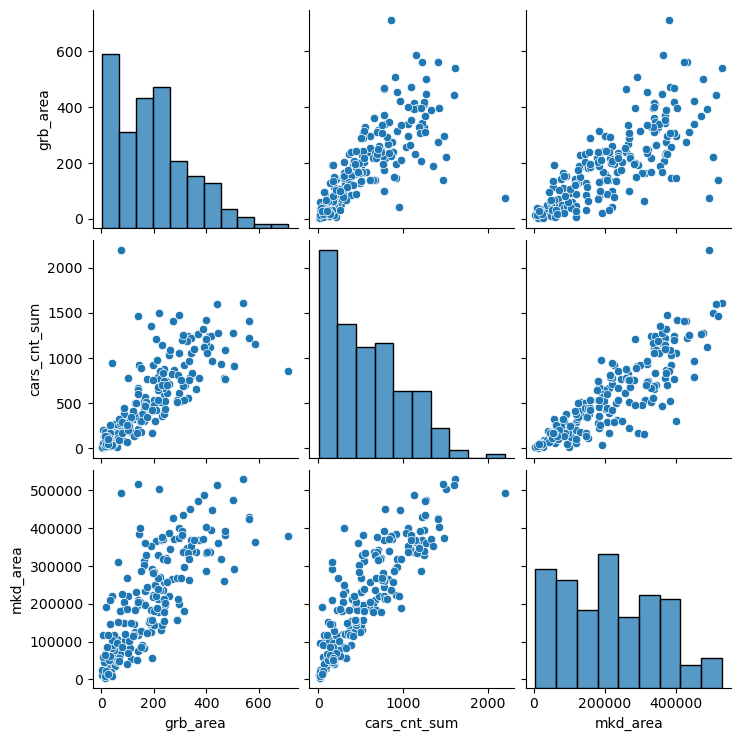

In [119]:
sns.pairplot(fin_df.sample(200))

/tmp/ipykernel_21121/3887192584.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fin_df.corr(), annot=True)


<AxesSubplot:>

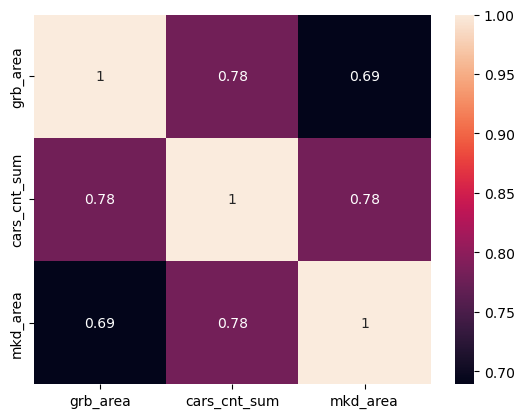

In [121]:
sns.heatmap(fin_df.corr(), annot=True)